In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import cv2 
import os 
import random

from keras.models import Sequential 
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import ReduceLROnPlateau

% matplotlib inline

In [2]:
!ls

 chest_xray		    chest_xray.zip   kaggle.json   sample_data
 chest-xray-pneumonia.zip  'kaggle .json'    __MACOSX


In [3]:
print(os.listdir('./chest_xray'))

['train', 'val', 'test', '.DS_Store']


In [15]:
print(os.listdir("./chest_xray/train"))
#print(os.listdir("./chest_xray/val"))
#print(os.listdir("./chest_xray/test"))

['PNEUMONIA', 'NORMAL', '.DS_Store']


**Data Directories**

In [0]:
TRAIN_DIR = './chest_xray/train'
VAL_DIR = './chest_xray/val'
TEST_DIR = './chest_xray/test'

In [21]:
# Training images distribution 
ntrain_normal = os.listdir('./chest_xray/train/NORMAL/')
ntrain_pneumonia = os.listdir('./chest_xray/train/PNEUMONIA')

print("Training images")
print("NORMAL : ", len(ntrain_normal))
print("PNEUMONIA : ", len(ntrain_pneumonia))

Training images
NORMAL :  1342
PNEUMONIA :  3876


**Ration of Normal and pneumonia affected lungs from dataset **

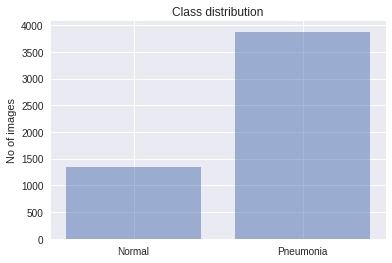

In [25]:
normal = len(ntrain_normal)
pneumonia = len(ntrain_pneumonia)

objects = ('Normal', 'Pneumonia')
y_pos = np.arange(len(objects))
y_axis = [normal, pneumonia]

plt.bar(y_pos, y_axis, align = 'center', alpha = 0.5 )
plt.xticks(y_pos, objects)
plt.ylabel('No of images')
plt.title("Class distribution")
plt.savefig('class_distribution.png')
plt.show()

Unbalanced dataset


**Plotting sample images **

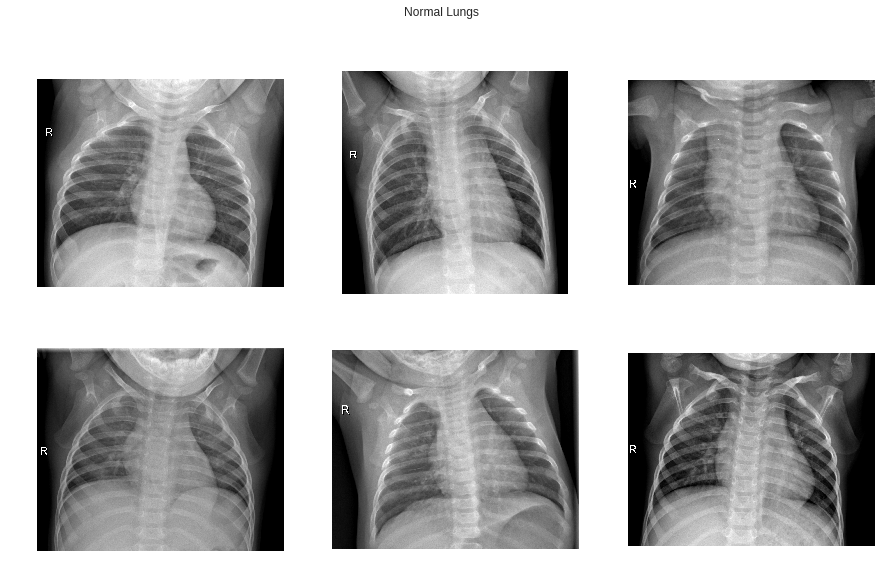

In [26]:
sample_normal = random.sample(ntrain_normal, 6)
f, ax = plt.subplots(2, 3, figsize = (15, 9))

for i in range(0, 6):
  im = cv2.imread('./chest_xray/train/NORMAL/'+sample_normal[i])
  ax[i//3, i%3].imshow(im)
  ax[i//3, i%3].axis('off')
f.suptitle('Normal Lungs')
plt.show()

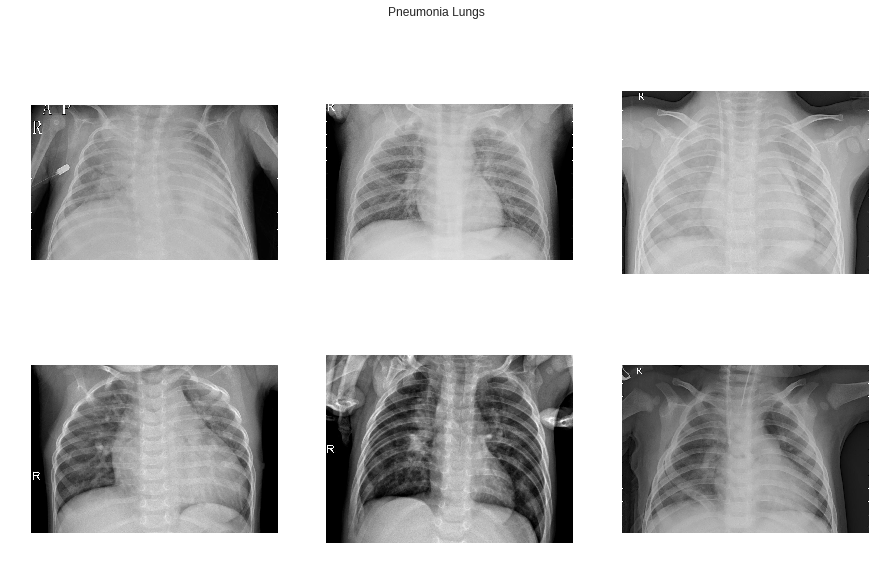

In [27]:
sample_pneumonia = random.sample(ntrain_pneumonia, 6)
f, ax = plt.subplots(2, 3, figsize = (15,  9))

for i in range(0, 6):
  im = cv2.imread('./chest_xray/train/PNEUMONIA/'+sample_pneumonia[i])
  ax[i//3, i%3].imshow(im)
  ax[i//3, i%3].axis('off')
f.suptitle('Pneumonia Lungs')
plt.show()

**Loading Data**

In [0]:
from tqdm import tqdm 
import skimage 
from skimage.transform import resize 

def preprocessData(DIR):
  
  X = []
  y = []
  
  for nextDir in os.listdir(DIR):
    if not nextDir.startswith('.'):
      if nextDir in ['NORMAL']:
        label = 0
      elif nextDir in ['PNEUMONIA']:
        label = 1 
      else: 
        label = 2  
        
      temp = DIR+'/'+nextDir 
      
      for file in tqdm(os.listdir(temp)):
        img = cv2.imread(temp+'/'+file)
        if img is not None:
          img = skimage.transform.resize(img,(150, 150, 3))
          img = np.asarray(img)
          
          X.append(img)
          y.append(label)
          
  X = np.asarray(X)
  y = np.asarray(y)
  
  return X, y 
  
  

In [39]:
print("\nProcessing Training Data ..........")
x_train, y_train = preprocessData(TRAIN_DIR)
print("\nProcessing Validation Data ..........")
x_val, y_val = preprocessData(VAL_DIR)
print("\nProcessing Testing Data ..........")
x_test, y_test = preprocessData(TEST_DIR)

  0%|          | 0/3876 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
  0%|          | 2/3876 [00:00<03:36, 17.85it/s]


Processing Training Data ..........


  0%|          | 0/9 [00:00<?, ?it/s]


Processing Validation Data ..........


  0%|          | 1/390 [00:00<00:40,  9.72it/s]


Processing Testing Data ..........


100%|██████████| 234/234 [00:34<00:00,  7.51it/s]


In [41]:
print(x_train.shape)
print(x_test.shape)

(5216, 150, 150, 3)
(624, 150, 150, 3)


In [43]:
print(y_train.shape)
print(y_test.shape)

(5216,)
(624,)


In [0]:
from keras.utils.np_utils import to_categorical 

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [47]:
print(y_train.shape, "/", y_test.shape)

(5216, 2) / (624, 2)


**Deep learning Model**

In [0]:
batch_size = 32
no_of_epochs = 6

In [50]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 

lr_reduce = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.1, epsilon = 0.0001, patience = 1, verbose =1)


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
filepath = 'model_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [53]:
from keras import backend as K
from keras.optimizers import SGD, RMSprop

def swish_activation(x):
  return (K.sigmoid(x) * x)

model = Sequential()

model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same', input_shape = (150, 150, 3)))
model.add(Conv2D(16, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same', input_shape = (150, 150, 3)))
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(96, (3, 3), activation = 'relu', padding = 'same', dilation_rate = (2, 2)))
model.add(Conv2D(96, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same', dilation_rate = (2, 2)))
model.add(Conv2D(128, (3, 3), padding = 'valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))


model.add(Flatten())

model.add(Dense(64, activation = swish_activation))
model.add(Dropout(0.4))
model.add(Dense(2, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr = 0.00005), metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [54]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
__________

In [55]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), callbacks = [lr_reduce, checkpoint], epochs = no_of_epochs)

Instructions for updating:
Use tf.cast instead.
Train on 5216 samples, validate on 624 samples
Epoch 1/6
5216/5216 [==============================] - 22s 4ms/step - loss: 0.5727 - acc: 0.7414 - val_loss: 0.6609 - val_acc: 0.6250

Epoch 00001: val_acc improved from -inf to 0.62500, saving model to model_weights.hdf5
Epoch 2/6
5216/5216 [==============================] - 16s 3ms/step - loss: 0.4379 - acc: 0.7915 - val_loss: 0.4369 - val_acc: 0.7853

Epoch 00002: val_acc improved from 0.62500 to 0.78526, saving model to model_weights.hdf5
Epoch 3/6
5216/5216 [==============================] - 16s 3ms/step - loss: 0.2762 - acc: 0.8846 - val_loss: 0.7136 - val_acc: 0.7019

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00003: val_acc did not improve from 0.78526
Epoch 4/6
5216/5216 [==============================] - 16s 3ms/step - loss: 0.1955 - acc: 0.9213 - val_loss: 0.3787 - val_acc: 0.8429

Epoch 00004: val_acc improved from 0.78526 to 0.84295, sa

In [71]:
Acc = history.history['acc']
print(Acc)

[0.7413726993865031, 0.7915069018404908, 0.8845858895705522, 0.9212998466257669, 0.9321319018404908, 0.9321319018404908]


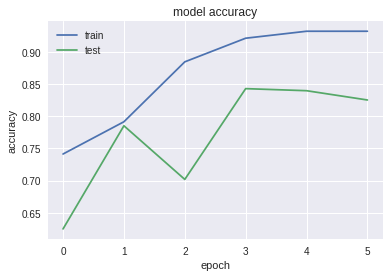

<Figure size 432x288 with 0 Axes>

In [57]:
import matplotlib.pyplot as plt 

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()
plt.savefig('model_accuracy.png')

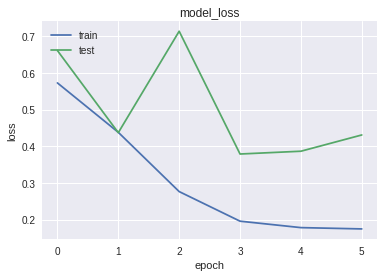

<Figure size 432x288 with 0 Axes>

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()
plt.savefig('model_loss.png')

**Model Evaluation **

In [76]:
print(y_test.shape)
print(pred.shape)

#scores = model.evaluate(x_test, pred)

(624, 2)
(624,)


In [83]:
pred_eval = to_categorical(pred, 2 )
scores = model.evaluate(x_test, pred_eval)

624/624 [==============================] - 1s 1ms/step


In [84]:
scores

[0.13136774244216773, 0.9935897435897436]

In [0]:
from sklearn.metrics import confusion_matrix 
pred = model.predict(x_test)
pred = np.argmax(pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)

In [0]:
CM = confusion_matrix(y_true, pred)

In [61]:
print(CM)

[[136  98]
 [ 13 377]]


In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_true, pred, target_names = ['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.91      0.58      0.71       234
   PNEUMONIA       0.79      0.97      0.87       390

   micro avg       0.82      0.82      0.82       624
   macro avg       0.85      0.77      0.79       624
weighted avg       0.84      0.82      0.81       624



In [66]:
 # precision = True Positive / (True Positive + False Positive)
  precision = 357 / (357 + 87)
  print(precision)

0.8040540540540541


In [67]:
# Recall = True Positive = (True Positive + False Negative)
Recall = 374 / (374 + 33)
print(Recall)

0.918918918918919


In [85]:
!ls

 chest_xray		   'kaggle .json'	 model_loss.png
 chest-xray-pneumonia.zip   kaggle.json		 model_weights.hdf5
 chest_xray.zip		    __MACOSX		 sample_data
 class_distribution.png     model_accuracy.png


In [0]:
#from google.colab import files 
#files.download('model_loss.png')
#files.download('model_accuracy.png')
#files.download('model_weights.hdf5')
#files.download('class_distribution.png')